In [15]:
import numpy as np 
import h5py
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
from IPython.display import HTML
from pathlib import Path

In [16]:
# J < 0: Ferromagnetic, J > 0: Antiferromagnetic
# Takes a configuration and the coefficient J and computes the energy.
def energy(conf, J):
    X, Y = conf.shape
    E = 0
    for x in range(X):
        for y in range(Y):
            E += J*conf[x,y]*conf[(x+1)%X,y]
            E += J*conf[x,y]*conf[x,(y+1)%Y]
    return E

# Computes the variation in energy for a spin flip given the configuration
# and the coordinates of the flipping site.
def calc_dE(conf, x, y, J):
    X, Y = conf.shape
    dE = 0
    dE -= 2*J * conf[x,y]*conf[(x-1)%X,y]
    dE -= 2*J * conf[x,y]*conf[(x+1)%X,y] 
    dE -= 2*J * conf[x,y]*conf[x,(y-1)%Y]
    dE -= 2*J * conf[x,y]*conf[x,(y+1)%Y]
    return dE


In [17]:
conf = np.random.choice([1,-1], (100,100))
print(energy(conf, 1))

-12


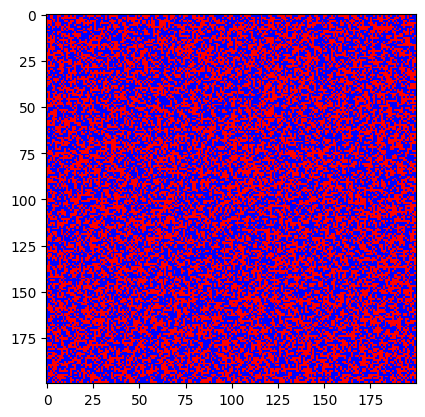

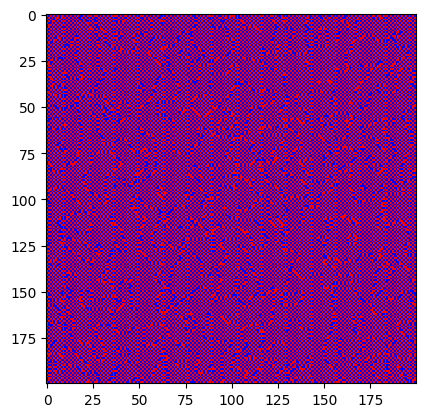

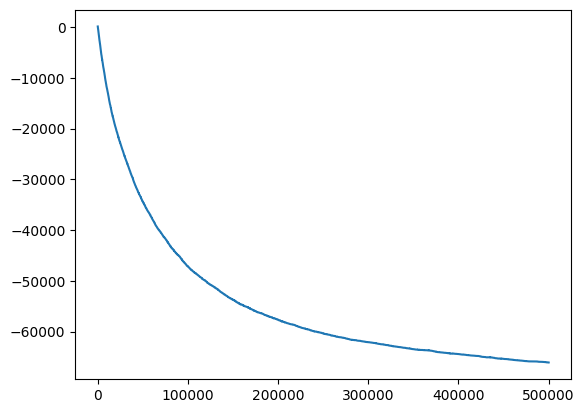

In [18]:
X = 200
Y = 200
J = 1 
T = 1 # temperature

# Initial state
conf = np.random.choice([1,-1], (X,Y))
conf[20,20]=-1

# Initial energy
E = energy(conf, J)
Es = [E] # we track the evolution of the energy

# Plot initial state
#plt.figure(figsize=(10, 10))
plt.imshow(conf, cmap='bwr', interpolation='none')
plt.show()

# We apply the metropolis algorithm N times
N = 500000
for i in range(N):
    # A site is chosen at random
    x = np.random.randint(0, X)
    y = np.random.randint(0, Y)

    # Compute the change in energy if we flip that site
    dE = calc_dE(conf, x, y, J)
    # Transition probability
    p = np.exp(-dE/T)
    # If the energy decreases, the site flips
    if dE <= 0:
        conf[x,y] = -conf[x,y]
        E += dE
    # If the energy increases, the site flips with probability p.
    elif np.random.rand() <= p:
            conf[x,y] = -conf[x,y]
            E += dE
    '''
    # This version flips always with probability p.
    if np.random.rand() <= p:
        conf[x,y] = -conf[x,y]
        E += dE
    '''
    Es.append(E)
        
#plt.figure(figsize=(10, 10))
plt.imshow(conf, cmap='bwr', interpolation='none')
plt.show()
plt.plot(Es)

plt.show()

The algorithm runs in O(N)! (N being the number of iterations). A bigger system doesn't take longer, as numpy array access is O(1) and each iteration only accesses the array and computes the energy difference, which takes 4 calculations.

In [ ]:
def load_states(filename):
  with h5py.File(filename, 'r') as f:
    states = f['configurations'][:]

    # Read metadata
    metadata = {
        'J': f['metadata'].attrs['J'],
        'T': f['metadata'].attrs['T'],
        'N': f['metadata'].attrs['N'],
        'X': f['metadata'].attrs['X'],
        'Y': f['metadata'].attrs['Y'],
        'step_size': f['metadata'].attrs['step_size'],
        'dimensions': (f['metadata'].attrs['X'], f['metadata'].attrs['Y'])
    }
  return states, metadata

def jupyter_animation(configurations, step_size, cmap='cool', fps=5):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Configuration initiale
    im = ax.imshow(configurations[0], cmap=cmap, vmin=-1, vmax=1)
    ax.axis('off')  # Enlever les axes pour plus de clarté
    title = ax.set_title("Frame 0", fontsize=14)
    
    # Fonction de mise à jour
    def update(frame):
        im.set_array(configurations[frame])
        title.set_text(f"Configuration {frame * step_size}")
        return [im, title]
    
    # Créer l'animation
    anim = FuncAnimation(fig, update, frames=len(configurations),
                        interval=1000/fps, blit=True)
    
    plt.tight_layout()

    save_path = Path('..').resolve() / 'animations' / 'ising_animation.gif'
    anim.save(save_path, writer='pillow', fps=fps) 
    print(f"Animation saved to {save_path}")
    
    # Afficher dans le notebook
    plt.close()
    return HTML(anim.to_jshtml())

In [13]:
path = Path('..').resolve() / 'data' / 'configs.h5'
states, metadata = load_states(path)
anim_html = jupyter_animation(states, metadata['step_size'], fps=20)
display(anim_html)

Animation saved to /Users/delta/Documents/PS/L2/research/ising-model-research/animations/ising_animation.gif
